Image Deconvolution (PGM Plug-and-Play Priors w/ BM3D)
======================================================

This example demonstrates the use of class
[pgm.AcceleratedPGM](../_autosummary/scico.optimize.rst#scico.optimize.AcceleratedPGM)
to solve an image deconvolution problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>
<cite data-cite="kamilov-2017-plugandplay"/>, using BM3D <cite data-cite="dabov-2008-image"/>
as a denoiser.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize.pgm import AcceleratedPGM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Set up forward operator and test signal consisting of blurred signal
with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / n**2
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape)
y = Ax + σ * noise

Set up and run a PGM solver.

In [4]:
f = loss.SquaredL2Loss(y=y, A=A)

L0 = 15  # APGM inverse step size parameter
λ = L0 * 2.0 / 255  # BM3D regularization strength
g = λ * functional.BM3D()

maxiter = 50  # number of APGM iterations

solver = AcceleratedPGM(
    f=f, g=g, L0=L0, x0=A.T @ y, maxiter=maxiter, itstat_options={"display": True, "period": 10}
)

print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      L          Residual 
------------------------------------
   0  9.25e+00  1.500e+01  2.070e+00


  10  7.86e+01  1.500e+01  6.057e-01


  20  1.42e+02  1.500e+01  2.156e-01


  30  2.05e+02  1.500e+01  1.733e-01


  40  2.67e+02  1.500e+01  1.863e-01


  49  3.22e+02  1.500e+01  1.855e-01


Show the recovered image.

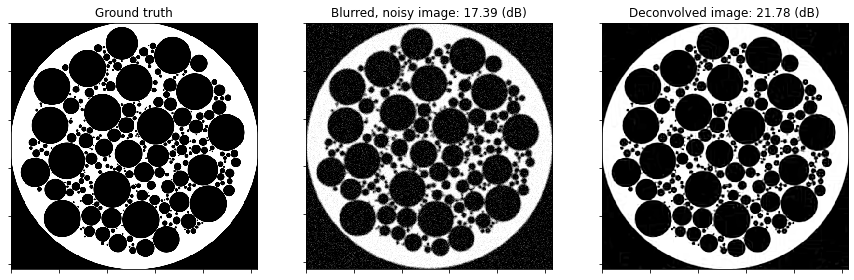

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
y = snp.clip(y, 0, 1)
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

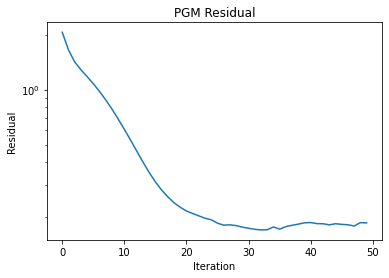

In [6]:
plot.plot(hist.Residual, ptyp="semilogy", title="PGM Residual", xlbl="Iteration", ylbl="Residual")